In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Connect to Kaggle

In [2]:
 !pip install -q kaggle

In [ ]:
from google.colab import files

files.upload() # upload API kaggle

In [ ]:
!mkdir ~/.kaggle # membuat direktori kaggle

!cp kaggle.json ~/.kaggle/ # copy file yang diupload ke direktori yang dibuat

!chmod 600 ~/.kaggle/kaggle.json # mengubah izin file

!mkdir dataset # buat direktori dataset

# Load Dataset

In [ ]:
!kaggle datasets download -d smid80/weatherww2

!unzip weatherww2.zip -d dataset

In [2]:
df = pd.read_csv('/content/dataset/Summary of Weather.csv')

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,MO,DA,PRCP,DR,SPD,MAX,MIN,MEA,SNF,SND,FT,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0,NaN,42,7,1,0.04,NaN,NaN,78.0,72.0,75.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0,NaN,42,7,2,0,NaN,NaN,84.0,71.0,78.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0,NaN,42,7,3,0.1,NaN,NaN,79.0,72.0,76.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0,NaN,42,7,4,0.1,NaN,NaN,80.0,72.0,76.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0,NaN,42,7,5,0,NaN,NaN,80.0,71.0,76.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(119040, 31)

In [4]:
df = df[['Date','MeanTemp']]

df.rename(columns={'Date': 'date', 'MeanTemp': 'mean_temp'}, inplace=True)

df.head()

,date,mean_temp
0,1942-7-1,23.888889
1,1942-7-2,25.555556
2,1942-7-3,24.444444
3,1942-7-4,24.444444
4,1942-7-5,24.444444


In [5]:
df.isna().sum()

date         0
mean_temp    0
dtype: int64

In [6]:
df.shape

(119040, 2)

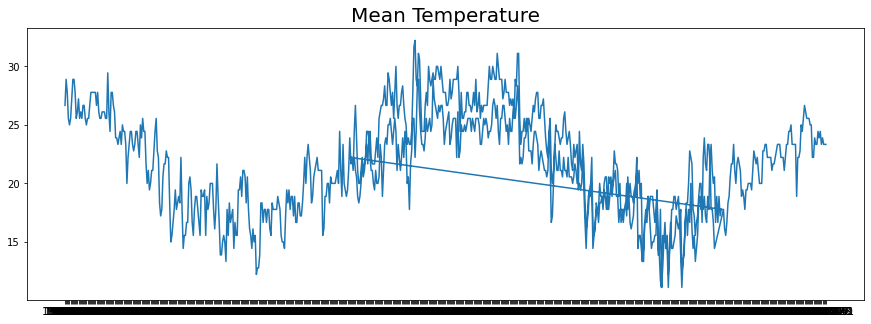

In [7]:
x = df['date'].values
y  = df['mean_temp'].values

plt.figure(figsize=(15,5))
plt.plot(x[-1000:], y[-1000:])
plt.title('Mean Temperature', fontsize=20);

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
train_set = windowed_dataset(y_train, window_size=64, batch_size=200, shuffle_buffer=1000)
valid_set = windowed_dataset(y_test, window_size=64, batch_size=200, shuffle_buffer=1000)

# Build Model

In [23]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60)),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

# Train Model

In [11]:
min = y.min()
max = y.max()

skala = len(range(int(min), int(max)))

low_limit = skala * 0.1

low_limit

7.5

In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<low_limit-2):
      print(f"\nMAE telah kurang dari 10% skala data ({low_limit})!")
      self.model.stop_training = True
callbacks = myCallback()

In [25]:
history = model.fit(train_set, 
                    epochs=10,
                    validation_data=valid_set,
                    steps_per_epoch=100,
                    callbacks=[callbacks]
                    )

Epoch 1/10
100/100 [==============================] - 14s 79ms/step - loss: 21.9976 - mae: 22.4967 - val_loss: 21.6162 - val_mae: 22.1150
Epoch 2/10
100/100 [==============================] - 7s 68ms/step - loss: 20.5191 - mae: 21.0177 - val_loss: 18.9939 - val_mae: 19.4923
Epoch 3/10
100/100 [==============================] - 7s 69ms/step - loss: 14.6600 - mae: 15.1571 - val_loss: 7.6315 - val_mae: 8.1259
Epoch 4/10
100/100 [==============================] - 7s 69ms/step - loss: 5.0283 - mae: 5.4962 - val_loss: 4.6845 - val_mae: 5.1465

MAE telah kurang dari 10% skala data (7.5)!


# Plot Loss & MAE

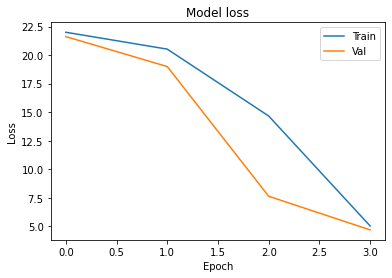

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

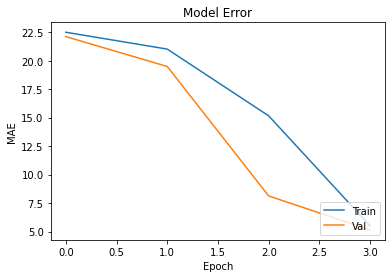

In [27]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()